# Home Loan Approval/Denial

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import (
    make_column_transformer,
    make_column_selector,
    ColumnTransformer,
)

from sklearn.metrics import classification_report

from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import chi2
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.svm import SVC

from sklearn import set_config

set_config(display="diagram")

#### Auxiliary variables

In [3]:
filename_input = "data-hdma-eastbay-2019-2022-processed"
filename_output = "data-hdma-eastbay-2019-2022-sklearn"

#### Loading the processed data

In [4]:
df = pd.read_csv(f"../../{filename_input}.csv", index_col=0)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222872 entries, 0 to 222871
Data columns (total 36 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   debt_to_income_ratio               222872 non-null  float64
 1   property_value                     222872 non-null  float64
 2   tract_median_age_of_housing_units  222872 non-null  float64
 3   tract_one_to_four_family_homes     222872 non-null  float64
 4   tract_owner_occupied_units         222872 non-null  float64
 5   tract_to_msa_income_percentage     222872 non-null  float64
 6   tract_minority_population_percent  222872 non-null  float64
 7   tract_population                   222872 non-null  float64
 8   income                             222872 non-null  float64
 9   loan_term                          222872 non-null  float64
 10  loan_amount                        222872 non-null  float64
 11  loan_to_value_ratio                222872 no

## 3. Preparing for modeling

### 3.1. Test features

In [6]:
df["sqrt_income"] = df["income"].apply(np.sqrt)
df["sqrt_property_value"] = df["property_value"].apply(np.sqrt)
df["sqrt_loan_amount"] = df["loan_amount"].apply(np.sqrt)

### 3.2. Lists of feature names

In [34]:
display(df['conforming_loan_limit'].value_counts())
pd.crosstab(df['conforming_loan_limit'], df['application_outcome'], normalize='index')

conforming_loan_limit
C     160714
NC     62158
Name: count, dtype: int64

application_outcome,Approved,Denied
conforming_loan_limit,,
C,0.587970,0.412030
NC,0.843528,0.156472


In [36]:
display(df['occupancy_type'].value_counts())
pd.crosstab(df['occupancy_type'], df['application_outcome'], normalize='index')

occupancy_type
Main residence         208184
Investment property     12681
Second residence         2007
Name: count, dtype: int64

application_outcome,Approved,Denied
occupancy_type,,
Investment property,0.538286,0.461714
Main residence,0.667616,0.332384
Second residence,0.555057,0.444943


In [37]:
display(df['hoepa_status'].value_counts())
pd.crosstab(df['hoepa_status'], df['application_outcome'], normalize='index')

hoepa_status
No                138192
not_applicable     84680
Name: count, dtype: int64

application_outcome,Approved,Denied
hoepa_status,,
No,1.000000,0.000000
not_applicable,0.103153,0.896847


In [39]:
tract_features = [x for x in df.columns if x.startswith("tract_")]

numerical_loan_features = ["debt_to_income_ratio", "loan_term", "loan_to_value_ratio"]
numerical_currency_features = ["property_value", "income", "loan_amount"]
numerical_sqrt_currency_features = [
    "sqrt_income",
    "sqrt_property_value",
    "sqrt_loan_amount",
]
categorical_applicant_features = [
    "applicant_sex",
    "applicant_race",
    "applicant_ethnicity",
    "applicant_age",
]
categorical_coapplicant_features = [
    "coapplicant_sex",
    "coapplicant_race",
    "coapplicant_ethnicity",
    "coapplicant_age",
]
categorical_loan_features = [
    "conforming_loan_limit",
    "occupancy_type",
    # "hoepa_status",
    "lien_status",
    "loan_purpose",
    "loan_type",
]
binary_features = [
    "applicant_age_above_62",
    "interest_only_payment",
    "business_or_commercial_purpose",
    "open-end_line_of_credit",
]

derived_features = [
    "derived_sex",
    "derived_race",
    "derived_ethnicity",
    "derived_loan_product_type",
]

target_related_features = ["denial_reason"]

target_feature = "application_outcome"

### 3.3. X,y

In [46]:
X = df[
    numerical_loan_features
    + numerical_currency_features
    + numerical_sqrt_currency_features
    + categorical_applicant_features
    + categorical_coapplicant_features
    + categorical_loan_features
    + binary_features
    # + derived_features
]
y = df[target_feature]

### 3.4. train/test split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=5
)

### 3.5. Column transformers

In [48]:
categorical_columns = X.select_dtypes(include=object).columns
numerical_columns = X.select_dtypes(include=float).columns

print(categorical_columns)
print(numerical_columns)

Index(['applicant_sex', 'applicant_race', 'applicant_ethnicity',
       'applicant_age', 'coapplicant_sex', 'coapplicant_race',
       'coapplicant_ethnicity', 'coapplicant_age', 'conforming_loan_limit',
       'occupancy_type', 'lien_status', 'loan_purpose', 'loan_type',
       'applicant_age_above_62', 'interest_only_payment',
       'business_or_commercial_purpose', 'open-end_line_of_credit'],
      dtype='object')
Index(['debt_to_income_ratio', 'loan_term', 'loan_to_value_ratio',
       'property_value', 'income', 'loan_amount', 'sqrt_income',
       'sqrt_property_value', 'sqrt_loan_amount'],
      dtype='object')


In [49]:
def main_column_transformer():
    return ColumnTransformer(
        [
            ("ohe", OneHotEncoder(sparse_output=False), categorical_columns),
            ("scaler", StandardScaler(), numerical_columns),
        ],
        remainder="drop",
        verbose_feature_names_out=False,
    )

## 4. Modeling

In [50]:
def get_info(model):
    print(f"train score = {model.score(X_train, y_train)}")
    print(f"test score = {model.score(X_test, y_test)}")

### 4.1. Testing models

#### 4.1.1. LogisticRegression

In [51]:
pipeline = Pipeline(
    [
        ("preprocess", main_column_transformer()),
        ("model", LogisticRegression(max_iter=1000)),
    ]
)
pipeline.fit(X_train, y_train)
get_info(pipeline)
print(classification_report(y_test, pipeline.predict(X_test)))

train score = 0.7423690789051984
test score = 0.7403009183093536
              precision    recall  f1-score   support

    Approved       0.76      0.89      0.82     44078
      Denied       0.68      0.46      0.54     22784

    accuracy                           0.74     66862
   macro avg       0.72      0.67      0.68     66862
weighted avg       0.73      0.74      0.73     66862



#### 4.1.2. K-Nearest Neighbors (KNN)

In [15]:
# pipeline = Pipeline(
#     [
#         ("preprocess", main_column_transformer()),
#         ("model", KNeighborsClassifier()),
#     ]
# )
# pipeline.fit(X_train, y_train)
# get_info(pipeline)
# print(classification_report(y_test, pipeline.predict(X_test)))

#### 4.1.3. Decision Tree

In [65]:
pipeline = Pipeline(
    [
        ("preprocess", main_column_transformer()),
        ("model", DecisionTreeClassifier(max_depth=3)),
    ]
)
pipeline.fit(X_train, y_train)
get_info(pipeline)
print(classification_report(y_test, pipeline.predict(X_test)))

train score = 0.7143131850522403
test score = 0.7146211600011965
              precision    recall  f1-score   support

    Approved       0.76      0.83      0.79     44078
      Denied       0.60      0.49      0.54     22784

    accuracy                           0.71     66862
   macro avg       0.68      0.66      0.67     66862
weighted avg       0.70      0.71      0.71     66862



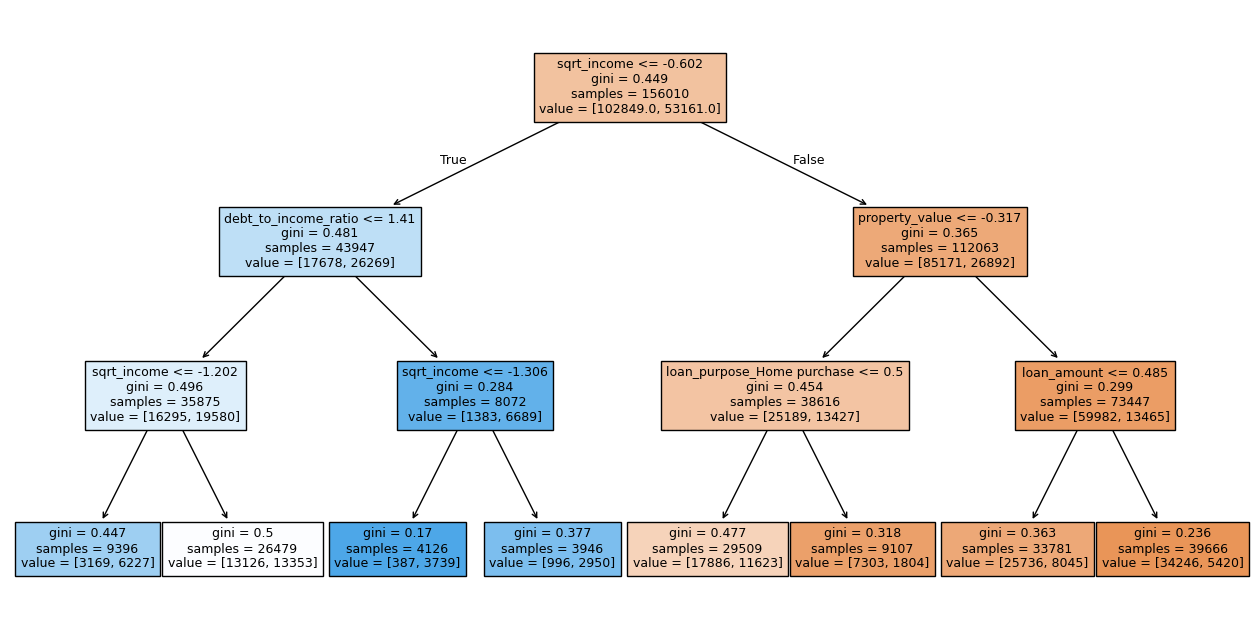

In [68]:
f, ax = plt.subplots(figsize=(16,8))
plot_tree(pipeline.named_steps['model'], feature_names = pipeline[0].get_feature_names_out(), fontsize=9, filled=True, ax=ax)
plt.show()

### 4.2. Searching hyperparameters

#### 4.2.1. LogisticRegression

In [58]:
pipeline = Pipeline(
    [
        ("preprocess", main_column_transformer()),
        ("model", LogisticRegression(max_iter=5000)),
    ]
)
grid_lr = GridSearchCV(
    pipeline,
    param_grid={
        "model__C": 10.0 ** np.array([-3, -2, -1, 0, 1]),
        "model__fit_intercept": [False, True],
    },
    verbose=4,
    cv=3,
).fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END model__C=0.001, model__fit_intercept=False;, score=0.739 total time=   1.0s
[CV 2/3] END model__C=0.001, model__fit_intercept=False;, score=0.736 total time=   1.1s
[CV 3/3] END model__C=0.001, model__fit_intercept=False;, score=0.739 total time=   1.1s
[CV 1/3] END model__C=0.001, model__fit_intercept=True;, score=0.739 total time=   1.1s
[CV 2/3] END model__C=0.001, model__fit_intercept=True;, score=0.736 total time=   1.1s
[CV 3/3] END model__C=0.001, model__fit_intercept=True;, score=0.739 total time=   1.1s
[CV 1/3] END model__C=0.01, model__fit_intercept=False;, score=0.743 total time=   1.2s
[CV 2/3] END model__C=0.01, model__fit_intercept=False;, score=0.740 total time=   1.3s
[CV 3/3] END model__C=0.01, model__fit_intercept=False;, score=0.742 total time=   1.2s
[CV 1/3] END model__C=0.01, model__fit_intercept=True;, score=0.743 total time=   1.3s
[CV 2/3] END model__C=0.01, model__fit_intercept=True;, s

In [59]:
get_info(grid_lr)

train score = 0.7424075379783347
test score = 0.7403906553797374


#### 4.2.3. Decision Tree

In [63]:
pipeline = Pipeline(
    [
        ("preprocess", main_column_transformer()),
        ("model", DecisionTreeClassifier()),
    ]
)
grid_lr = GridSearchCV(
    pipeline,
    param_grid={
        "model__criterion": ['gini', 'entropy', 'log_loss'],
        "model__max_depth": [4, 8, 16, 32],
        'model__min_samples_split': [2, 4, 8, 16, 32],
        'model__min_samples_leaf': [1, 2, 4, 8, 16, 32],
    },
    verbose=4,
    cv=3,
).fit(X_train, y_train)

Fitting 3 folds for each of 360 candidates, totalling 1080 fits
[CV 1/3] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=1, model__min_samples_split=2;, score=0.731 total time=   1.1s
[CV 2/3] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=1, model__min_samples_split=2;, score=0.728 total time=   1.2s
[CV 3/3] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=1, model__min_samples_split=2;, score=0.729 total time=   1.2s
[CV 1/3] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=1, model__min_samples_split=4;, score=0.731 total time=   1.2s
[CV 2/3] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=1, model__min_samples_split=4;, score=0.728 total time=   1.2s
[CV 3/3] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=1, model__min_samples_split=4;, score=0.729 total time=   1.2s
[CV 1/3] END model__criterion=gini, model__max_depth=4, model__min_samples_lea

In [64]:
get_info(grid_lr)

train score = 0.7775591308249471
test score = 0.7493194938829231
